# Preprocessing Audio Data

## Import Libraries

In [18]:
from datasets import load_dataset, Audio
import gradio as gr

import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [2]:
from transformers import WhisperFeatureExtractor

## Load the Dataset

In [3]:
minds = load_dataset("PolyAI/minds14", name="de-DE", split="train")
minds

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/datasets/load.py:1429: FutureWarning: The repository for PolyAI/minds14 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/PolyAI/minds14
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 611
})

## Change Sampling Rate

In [4]:
minds = minds.cast_column("audio", Audio(sampling_rate=16_000))

In [5]:
minds[0]

{'path': '/Users/Timothy/.cache/huggingface/datasets/downloads/extracted/574ee60c56f2a98e3a25ee703a29771dfbc083c018914572e359b4acabb80b50/de-DE~CASH_DEPOSIT/response_4.wav',
 'audio': {'path': '/Users/Timothy/.cache/huggingface/datasets/downloads/extracted/574ee60c56f2a98e3a25ee703a29771dfbc083c018914572e359b4acabb80b50/de-DE~CASH_DEPOSIT/response_4.wav',
  'array': array([-1.11991540e-07,  9.51089896e-06,  5.26400981e-07, ...,
          3.63070145e-03,  2.57458771e-03,  1.28283433e-03]),
  'sampling_rate': 16000},
 'transcription': 'ich möchte gerne Geld auf mein Konto einzahlen',
 'english_transcription': 'I would like to deposit money into my account',
 'intent_class': 7,
 'lang_id': 1}

In [6]:
id2label = minds.features["intent_class"].int2str

def generate_audio():
    example = minds.shuffle()[0]
    audio = example["audio"]
    
    return (
        audio["sampling_rate"],
        audio["array"],
    ), id2label(example["intent_class"])


with gr.Blocks() as demo:
    with gr.Column():
        for _ in range(4):
            audio, label = generate_audio()
            output = gr.Audio(audio, label=label)

demo.launch(debug=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/gradio/processing_utils.py:387: UserWarning: Trying to convert audio automatically from float64 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


## Filter the Data

In [7]:
# use librosa to get example's duration from the audio file
new_column = [librosa.get_duration(path=x) for x in minds["path"]]
minds = minds.add_column("duration", new_column)

In [8]:
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id', 'duration'],
    num_rows: 611
})

In [9]:
minds['duration'][:10]

[5.851375, 13.397375, 8.6, 5.387, 13.312, 7.68, 7.12, 13.568, 7.594625, 11.776]

In [10]:
min(minds['duration']), max(minds['duration'])

(2.56, 35.88)

In [11]:
MAX_DURATION_IN_SECONDS = 20.0

def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

In [12]:
# use 🤗 Datasets' `filter` method to apply the filtering function
minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])

Filter:   0%|          | 0/611 [00:00<?, ? examples/s]

In [13]:
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id', 'duration'],
    num_rows: 559
})

In [14]:
min(minds['duration']), max(minds['duration'])

(2.56, 19.9)

In [15]:
# remove the temporary helper column
minds = minds.remove_columns(["duration"])
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 559
})

## Preprocessing

In [16]:
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

In [17]:
def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], padding=True
    )
    return features

minds = minds.map(prepare_dataset)
minds

Map:   0%|          | 0/559 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id', 'input_features'],
    num_rows: 559
})

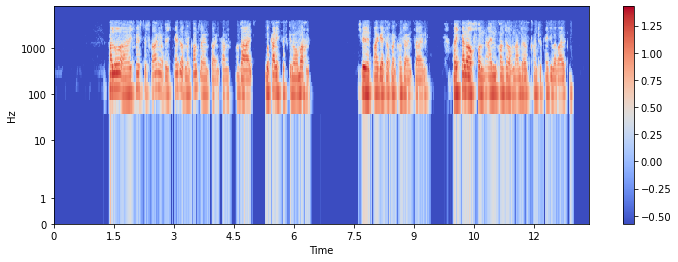

In [20]:
example = minds[1]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()